## Xenium vascularisation and growth factor genes plotting

In [1]:
import sys 
import os
from datetime import datetime
today = datetime.now().strftime("%Y-%m-%d")
import anndata as ad
import hdf5plugin
#import squidpy as sq
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

import scvi
import cellcharter as cc
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

In [2]:
# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/Spatial_analyses/'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')

%reload_ext autoreload

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', vector_friendly = True, format = 'pdf',  dpi_save=300)
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [5]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
model_path = os.path.join(repo_path, 'models')
results_path = os.path.join(repo_path, 'results')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [6]:
import seaborn as sns
thyAgeing_colors = pd.read_csv("/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing_colors.csv").set_index('color_name')['hex'].to_dict()
niche_enrich_palette = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,)

In [27]:
dotplot_cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True)

In [7]:
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette

In [8]:
thyAgeing_colors

{'blue': '#648FFF',
 'purple': '#785EF0',
 'magenta': '#DC267F',
 'orange': '#FE6100',
 'yellow': '#FFB000',
 'teal': '#18868F',
 'mint': '#738B79',
 'pink': '#C169E8',
 'grass': '#82CD29',
 'forest': '#124420'}

## Load CellCharter results

In [9]:
xenium_adata = ad.read_h5ad('/nfs/team205/vk8/projects/thymus_ageing_atlas/cellxgene/raw_data/ThyAge_xenium_adata_PaedAdult_filt_raw_2025-10-23.zarr')

In [11]:
ctypes_lev2 = get_ct_levels(level = 'taa_l2_v2')
ctypes_lev3 = get_ct_levels(level = 'taa_l3')
np.setdiff1d(ctypes_lev2, xenium_adata.obs['taa_l2_v2'])
np.setdiff1d(xenium_adata.obs['taa_l2_v2'], ctypes_lev2)
ctypes_lev2.remove('DC')
np.setdiff1d(ctypes_lev3, xenium_adata.obs['taa_l3'])
np.setdiff1d(xenium_adata.obs['taa_l3'], ctypes_lev3)
ctypes_lev3.remove('DC')
#[ctypes_lev3.remove(ct) for ct in ['B_med', 'DC', 'T_CD4_naive_recirc']]

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


array(['DC'], dtype='<U12')

array([], dtype=object)

array(['B_med', 'DC', 'T_CD4_naive_recirc'], dtype='<U18')

array([], dtype=object)

In [12]:
get_ct_levels(level = 'taa_l1')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


['T',
 'NK',
 'TEC',
 'Fb',
 'Adipocyte',
 'EC',
 'Mural',
 'B',
 'Myeloid_dev',
 'Neutrophil',
 'Mono',
 'Mac',
 'DC',
 'Mast']

In [13]:
fb_ctypes_lev3 = get_ct_levels(level = 'taa_l3', taa_l1=['Fb'])+['Adipocyte']
vasc_ctypes_lev3 = get_ct_levels(level = 'taa_l3', taa_l1=['EC','Mural'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [14]:
fb_ctypes_lev3
vasc_ctypes_lev3

['Fb-interlo', 'Fb-perilo', 'Fb-med', 'Fb-interm', 'Fb-adipo', 'Adipocyte']

['EC-art',
 'EC-cap',
 'EC-cap_lipid',
 'EC-ven',
 'EC-peri',
 'EC-lymphatic',
 'SMC',
 'Pericyte']

In [15]:
xenium_adata.obs['taa_l2_v2'] = xenium_adata.obs['taa_l2_v2'].cat.reorder_categories(ctypes_lev2).copy()
xenium_adata.obs['taa_l3'] = xenium_adata.obs['taa_l3'].cat.reorder_categories([ct for ct in ctypes_lev3 if ct in xenium_adata.obs['taa_l3'].cat.categories.tolist()]).copy()

In [16]:
xenium_adata.obs['niche_cellcharter6'] = xenium_adata.obs['niche_cellcharter6'].cat.reorder_categories (['Capsule/PVS', 'Cortex','Medulla',
       'mcTEC-rich', 'InflammatoryPVS','Adipose']).copy()

### Vascular growth factors and receptors

In [17]:
endothelial_lr = {
    # --- VEGF family ---
    "VEGFA": ["KDR", "FLT1"],
    "VEGFB": ["FLT1"],
    "VEGFC": ["FLT4"],
    # --- FGF family ---
    "FGF2": ["FGFR1", "FGFR2"],
    "FGF1": ["FGFR1"],
    # --- Angiopoietins ---
    "ANGPT2": ["TEK"],  # often destabilizing, context-dependent
    # --- Notch signaling ---
    "DLL4": ["NOTCH1", "NOTCH4"],
    "JAG1": ["NOTCH1"],
    # --- Chemokines ---
    "CXCL12": ["CXCR4", "CXCR7"],
    "CXCL8": ["CXCR1", "CXCR2"],
    # --- PDGF family ---
    "PDGFB": ["PDGFRB"],
    # --- Apelin ---
    "APLN": ["APLNR"],
    # --- Ephrin signaling ---
    "EFNB2": ["EPHB4"],
    # --- Growth and morphogens ---
    "HGF": ["MET"],
    "TGFB1": ["TGFBR1", "TGFBR2"],
    "BMP9": ["ACVRL1", "ENG"],
    "NRG1": ["ERBB4"],
    "SLIT2": ["ROBO4"]
}

In [18]:
endothelial_lr_xen = {}
for lig, rec in endothelial_lr.items():
    if lig in xenium_adata.var_names.tolist():
        endothelial_lr_xen[lig] = [i for i in rec if i in xenium_adata.var_names.tolist()]
    

In [22]:
plt.style.use(f'/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

In [35]:
vasc_lig_xen = list(endothelial_lr_xen.keys())

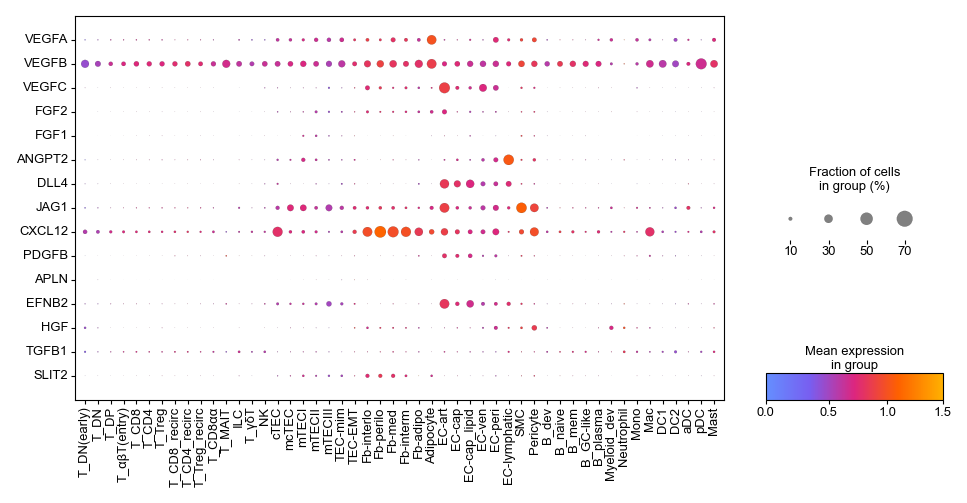

In [67]:
sc.pl.dotplot(xenium_adata, var_names = vasc_lig_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                            vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,3), return_fig=True).style(smallest_dot=0, largest_dot = 50,dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_all_ctypes_combined_dotplot.pdf')

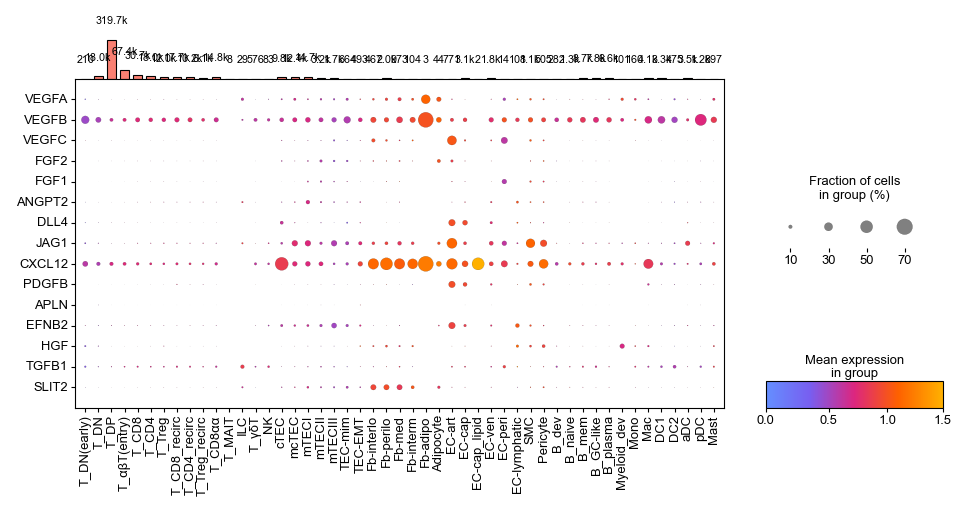

In [66]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'paed(late)'], var_names = vasc_lig_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
              vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,3), return_fig=True).style(smallest_dot=0, largest_dot = 50,dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/Xenium_Vascularisation_lig_all_ctypes_paed_dotplot.pdf')

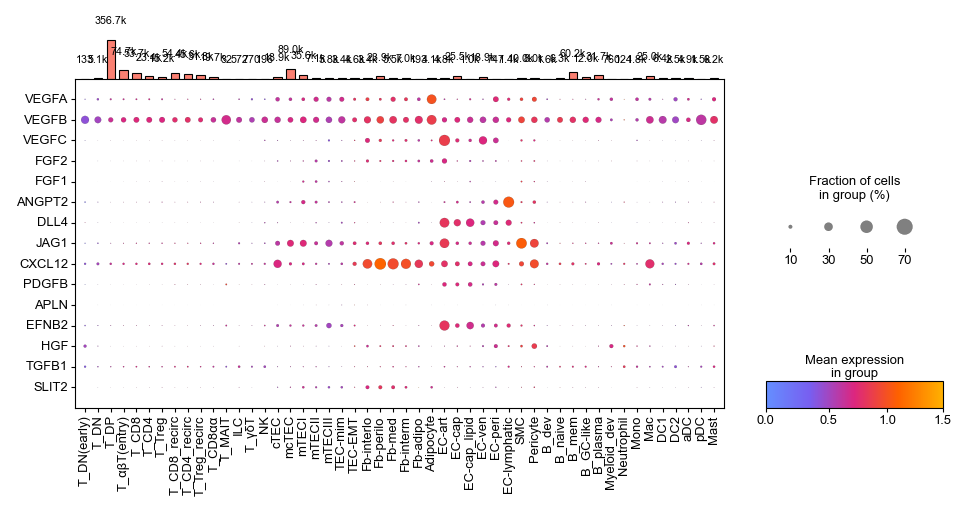

In [65]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'adult'], var_names = vasc_lig_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
              vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,3), return_fig=True).style(smallest_dot=0, largest_dot = 50,dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/Xenium_Vascularisation_lig_all_ctypes_adult_dotplot.pdf')

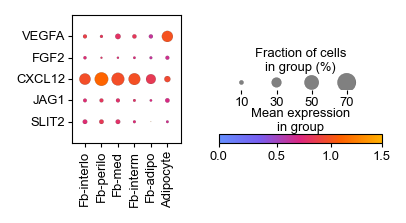

In [54]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['taa_l3'].isin(fb_ctypes_lev3)], var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], 
              groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, 
              dot_max= 0.7, figsize = (2.5,1.0), return_fig=True).style(smallest_dot=0, largest_dot = 70, 
              dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot.pdf') 

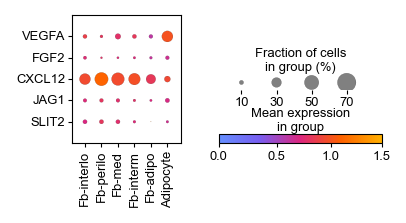

In [68]:
sc.pl.dotplot(xenium_adata[(xenium_adata.obs['taa_l3'].isin(fb_ctypes_lev3)) & (xenium_adata.obs['Age_group'] == 'adult')], var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], 
              groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, 
              dot_max= 0.7, figsize = (2.5,1.0), return_fig=True).style(smallest_dot=0, largest_dot = 70, 
              dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot_adultFBs.pdf') 

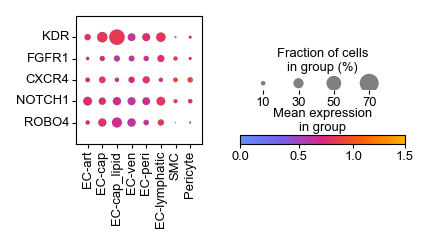

In [ ]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['taa_l3'].isin(vasc_ctypes_lev3)], 
              var_names = ['KDR', 'FGFR1', 'CXCR4', 'NOTCH1', 'ROBO4'], groupby = 'taa_l3', swap_axes = True,cmap = dotplot_cmap, 
              mean_only_expressed=True, dot_max=0.7, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), return_fig=True).style(smallest_dot=0, largest_dot = 70, 
              dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_rec_dotplot.pdf') 

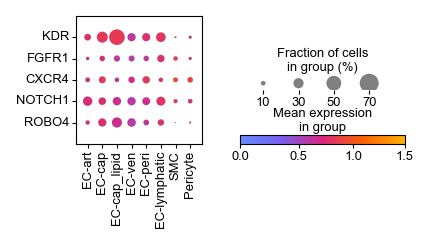

In [69]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['taa_l3'].isin(vasc_ctypes_lev3) & (xenium_adata.obs['Age_group'] == 'adult')], 
              var_names = ['KDR', 'FGFR1', 'CXCR4', 'NOTCH1', 'ROBO4'], groupby = 'taa_l3', swap_axes = True,cmap = dotplot_cmap, 
              mean_only_expressed=True, dot_max=0.7, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), return_fig=True).style(smallest_dot=0, largest_dot = 70, 
              dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_rec_dotplot_adultVasc.pdf') 

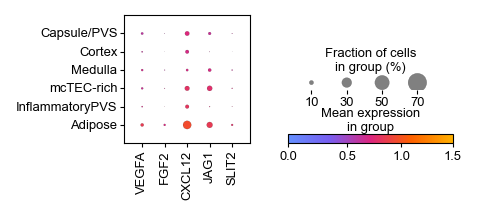

In [72]:
sc.pl.dotplot(xenium_adata, var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, dot_max=0.7, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot_niches.pdf') 

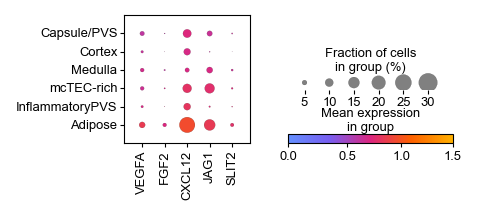

In [73]:
sc.pl.dotplot(xenium_adata, var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot_niches.pdf') 

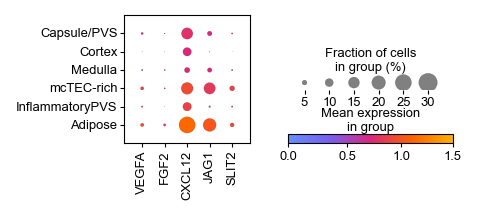

In [74]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'paed(late)'], var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot_Peadniches.pdf') 

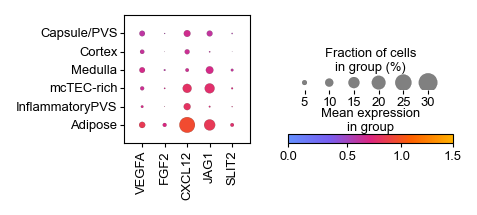

In [75]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'adult'], var_names = ['VEGFA', 'FGF2', 'CXCL12', 'JAG1', 'SLIT2'], groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_Vascularisation_lig_dotplot_Adultniches.pdf') 

In [86]:
xenium_adata.obs.loc[xenium_adata.obs['Age_group'] == 'paed(late)',].groupby(['niche_cellcharter6'], observed = True).size()
xenium_adata.obs.loc[xenium_adata.obs['Age_group'] == 'adult',].groupby(['niche_cellcharter6'], observed = True).size()

niche_cellcharter6
Capsule/PVS         84677
Cortex             372946
Medulla            121103
mcTEC-rich           1886
InflammatoryPVS     21754
Adipose              5413
dtype: int64

niche_cellcharter6
Capsule/PVS        163395
Cortex             344020
Medulla            143753
mcTEC-rich         143461
InflammatoryPVS    221062
Adipose            106121
dtype: int64

## IGF growth factors and receptors

In [126]:
igf_gene_groups = {
    "IGF_ligands": [
        "IGF1",
        "IGF2"
    ],
    "IGF_receptors": [
        "IGF1R",
        "IGF2R",
        "INSR",
        "INSRR"
    ],
    "IGF_binding_proteins": [
        "IGFBP1",
        "IGFBP2",
        "IGFBP3",
        "IGFBP4",
        "IGFBP5",
        "IGFBP6",
        "IGFBP7"
    ],
    "IGFBP_related_proteins": [
       # often grouped here too
        "CCN1",    # CYR61
        "CCN2",      # CTGF, IGFBP8
      #  "NOV"     # also known as CCN3
    ],
    "IGF_complex_partners": [
        "IGFALS"
    ]
}

In [96]:
igf_gene_groups_xen = {group: [gene for gene in genes if gene in xenium_adata.var_names.tolist()]
                       for group, genes in igf_gene_groups.items()}


In [100]:
igf_gene_groups_xen.pop('IGF_complex_partners', None)

In [101]:
igf_gene_groups_xen

{'IGF_ligands': ['IGF1', 'IGF2'],
 'IGF_receptors': ['IGF1R', 'IGF2R', 'INSR', 'INSRR'],
 'IGF_binding_proteins': ['IGFBP1', 'IGFBP2'],
 'IGFBP_related_proteins': ['CCN1', 'CCN2']}

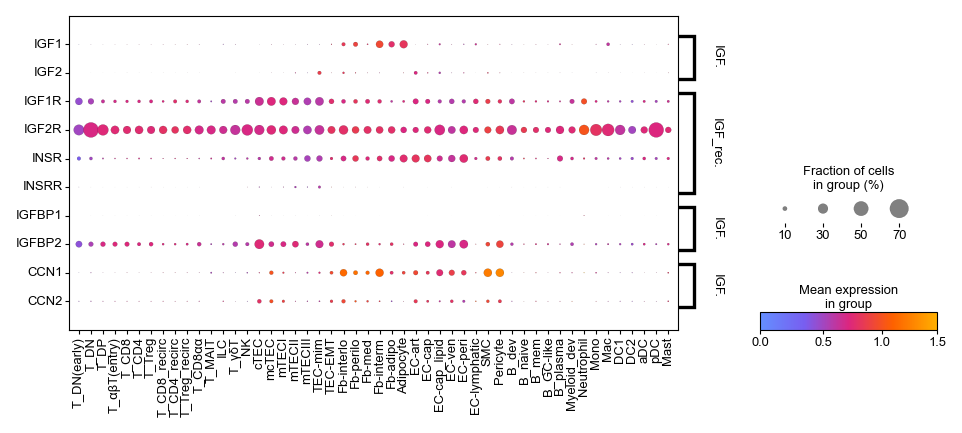

In [105]:
sc.pl.dotplot(xenium_adata, var_names = igf_gene_groups_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                           vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_IGF_all_ctypes_combined_dotplot.pdf')

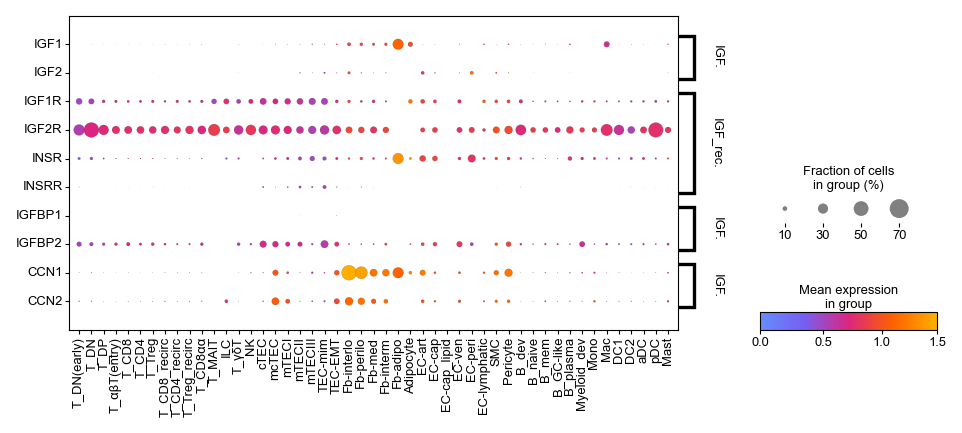

In [109]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'paed(late)'], var_names = igf_gene_groups_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                           vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_IGF_all_ctypes_Paed_dotplot.pdf')

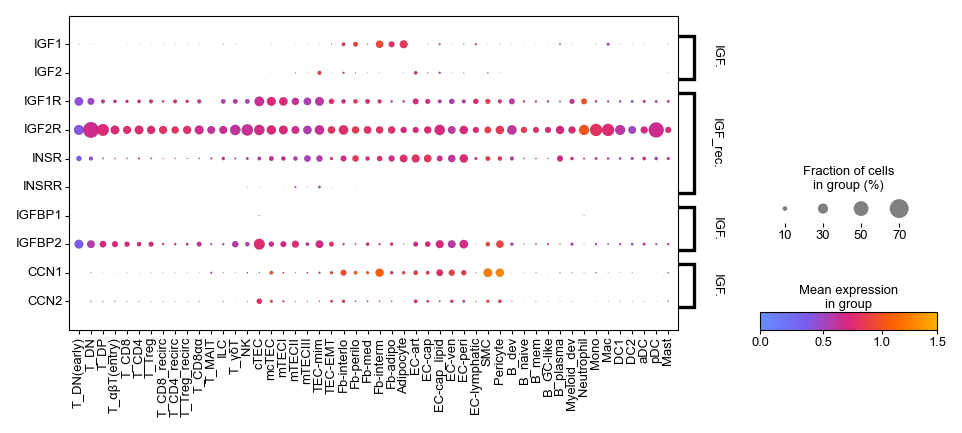

In [107]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'adult'], var_names = igf_gene_groups_xen, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                           vmin = 0, vcenter = 0.7, vmax = 1.5, dot_max= 0.7,
              figsize = (7,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_IGF_all_ctypes_Adult_dotplot.pdf')

In [115]:
scell_adata = ad.read_h5ad('/nfs/team205/vk8/projects/thymus_ageing_atlas/cellxgene/ThyAge_all_2025-10-14.zarr')

In [119]:
np.setdiff1d(ctypes_lev3,scell_adata.obs['taa_l3'].cat.categories)

array(['Adipocyte', 'B_med', 'EC-peri'], dtype='<U18')

In [122]:
scell_adata.obs['taa_l3'] = scell_adata.obs['taa_l3'].cat.reorder_categories([ct for ct in ctypes_lev3 if ct in scell_adata.obs['taa_l3'].cat.categories]).copy()

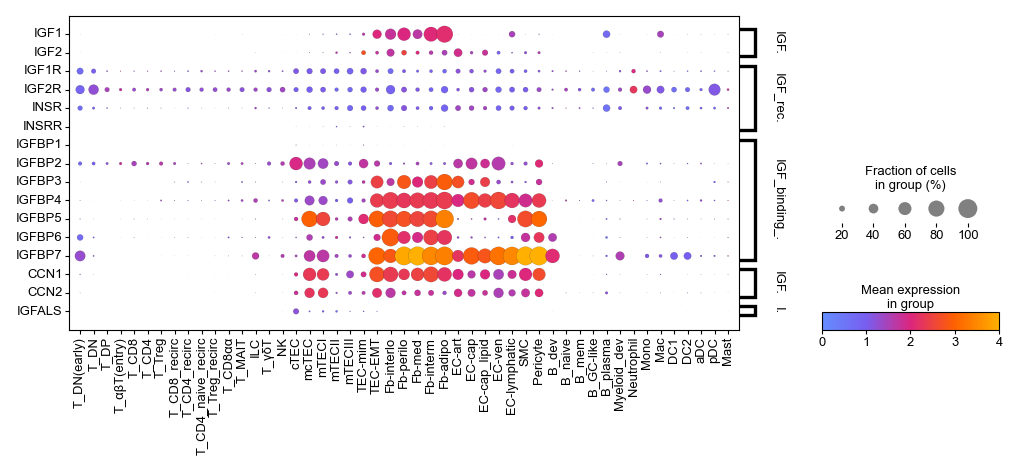

In [128]:
sc.pl.dotplot(scell_adata, var_names = igf_gene_groups, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                          vmin = 0, vcenter = 2, vmax = 4, dot_max= 1,
              figsize = (7.5,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Scell_IGF_all_ctypes_combined_dotplot.pdf')

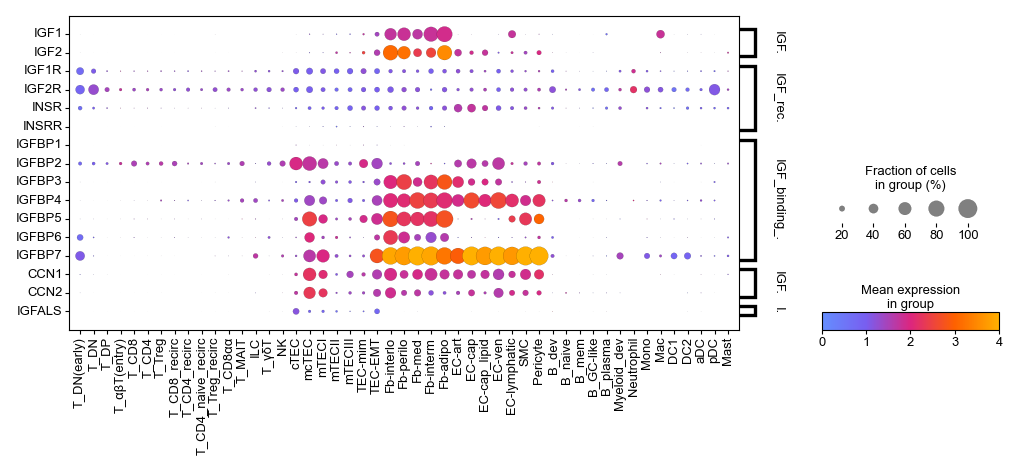

In [131]:
sc.pl.dotplot(scell_adata[scell_adata.obs['age_group'] == 'infant'], var_names = igf_gene_groups, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                          vmin = 0, vcenter = 2, vmax = 4, dot_max= 1,
              figsize = (7.5,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Scell_IGF_all_ctypes_infant_dotplot.pdf')

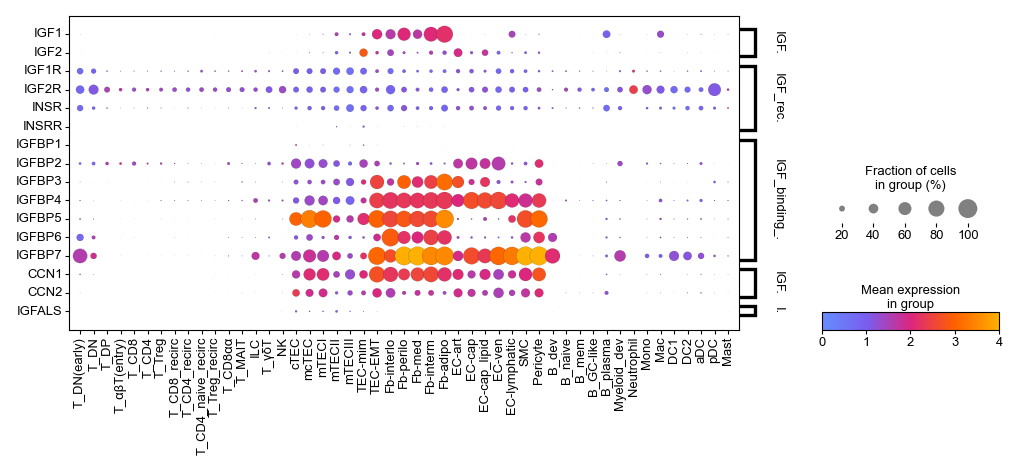

In [130]:
sc.pl.dotplot(scell_adata[scell_adata.obs['age_group'] == 'adult'], var_names = igf_gene_groups, groupby = 'taa_l3', swap_axes = True, cmap = dotplot_cmap, mean_only_expressed=True,
                          vmin = 0, vcenter = 2, vmax = 4, dot_max= 1,
              figsize = (7.5,2), return_fig=True).style(smallest_dot=0, largest_dot = 70,dot_edge_lw=0.05).savefig(f'{plot_path}/Scell_IGF_all_ctypes_adult_dotplot.pdf')

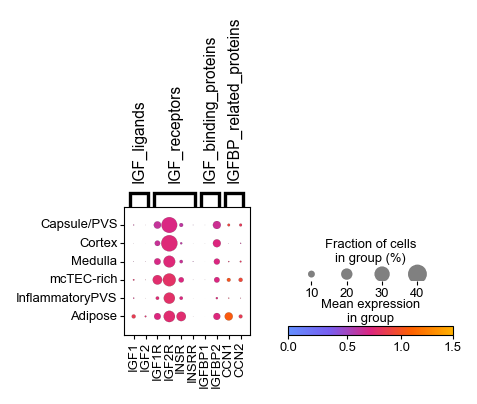

In [110]:
sc.pl.dotplot(xenium_adata, var_names = igf_gene_groups_xen, groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5, figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_GH_dotplot_niches.pdf') 

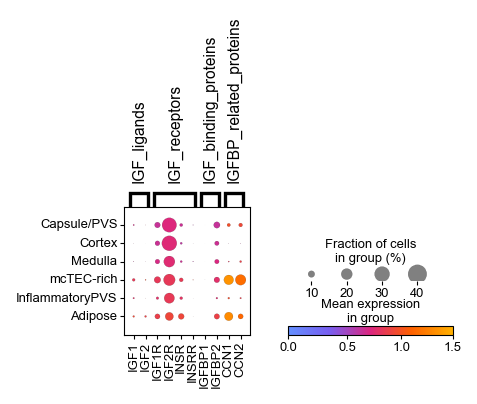

In [113]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'paed(late)'], var_names = igf_gene_groups_xen, groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5,  dot_max= 0.4,figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_GH_dotplot_niches_epaed.pdf') 

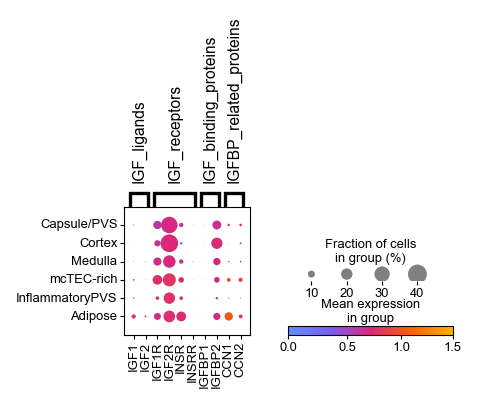

In [114]:
sc.pl.dotplot(xenium_adata[xenium_adata.obs['Age_group'] == 'adult'], var_names = igf_gene_groups_xen, groupby = 'niche_cellcharter6', 
              cmap = dotplot_cmap, mean_only_expressed=True, vmin = 0, vcenter = 0.7, vmax = 1.5,  dot_max= 0.4,figsize = (2.65,1.0), 
              return_fig=True).style(smallest_dot=0, largest_dot = 70, dot_edge_lw=0.05).savefig(f'{plot_path}/Xenium_GH_dotplot_niches_adult.pdf') 